In [1]:
import numpy as np
import scipy.sparse as sps
from matplotlib import pyplot as plt
import sys
from tqdm.notebook import tqdm
sys.path.append("../../") # wherever spook is installed

In [2]:
from spook import SpookLinSolve, SpookPosL1

from spook.utils import dict_innerprod, calcL2fromContracted

In [3]:
Na = 37
Nb = 29
Ns = 50000
Ng = 31

A = np.random.rand(Ns, Na) * 5
Xtrue = np.zeros((Na, Nb))
bb, aa = np.meshgrid(np.arange(Nb), np.arange(Na))
for p1, p2 in zip([1,-1],[1,-1]):
    tmp = 0.1*(Na+Nb) - abs((aa - Na//2) + p1* (bb - Nb//2) - p2* 0.2*(Na+Nb))
    tmp[tmp<0] = 0
    Xtrue += tmp

G = np.identity(Ng) + 0.2*np.diag(np.ones(Ng-1),k=-1) + 0.2*np.diag(np.ones(Ng-1),k=1)
G = G[:,:Nb]

Text(0, 0.5, '$\\omega$')

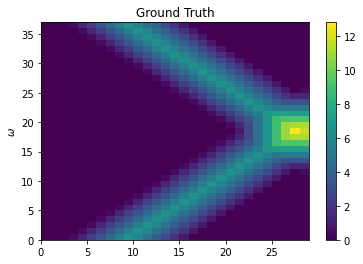

In [4]:
plt.pcolormesh(Xtrue)
plt.colorbar()
plt.title("Ground Truth")
plt.ylabel("$\omega$")

Sample `B` from the ground truth with `numpy.random.poisson`

In [5]:
gaussian_noise_level = 3e-3
# with G=None
rng = np.random.default_rng(2022)
B0 = rng.poisson(A @ Xtrue).astype(float)
B0 += np.linalg.norm(B0)*rng.normal(size=(B0.shape))*gaussian_noise_level
# with non-trivial G
rng = np.random.default_rng(2022)
B1 = rng.poisson(A @ Xtrue @ G.T).astype(float)
B1 += np.linalg.norm(B1)*rng.normal(size=(B1.shape))*gaussian_noise_level
print(B0.shape, B1.shape)

(50000, 29) (50000, 31)


Data set `(A,B0)` is ready. 
## Apply spooktroscopy at a blindly-chosen hyperparameter

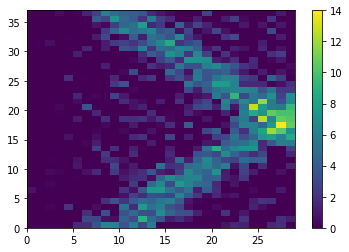

In [6]:
spk0 = SpookPosL1(B0, A, "raw", lsparse=0.1, lsmooth=(0.,0.0))

X0 = spk0.getXopt()
plt.pcolormesh(X0)
plt.colorbar()

## Cross validate

In [38]:
def kFold_split(nfold, indices, shuffle=False, random_state=None):
    """
    Generate (train, test) splits in indices
    returns a list of nfold (train, test) splits. 
    For more details, google k-fold cross-validation
    """
    if isinstance(indices, int):
        indices = np.arange(indices)
    indices = np.asarray(indices)
    if shuffle:
        np.random.seed(random_state)
        indices = np.random.permutation(indices)
    idc_split = np.array_split(indices, nfold)
    out = []
    for k, test in enumerate(idc_split):
        train = np.concatenate([trn for k1, trn in enumerate(idc_split) if k1!=k])
        out.append((train, test))
    return out

def contracted_dataset_generate(splits, A, B, Wb=None):
    dsets = {"train":[],"valid":[]}
    val_prectrsets = dsets['valid']
    for trn, tst in splits:
        A1, B1 = A[tst], B[tst]
        BtB = abs(B1)**2
        if Wb is not None: BtB = BtB * Wb
        val_prectrsets.append({"AtA":A1.T @ A1,
                       "AtB":A1.T @ B1,
                       'trBtB': BtB.sum(),
                       "Ns":tst.size})
    for j, pctst in enumerate(val_prectrsets):
        pctrn = {}
        for ky in pctst.keys(): # accumulate the four quantities separately
            pctrn[ky]  = np.sum([pctst1[ky] for j1, pctst1 in enumerate(val_prectrsets) if j1!=j], axis=0)
        dsets['train'].append(pctrn)
    for j, (trn, tst) in enumerate(splits):
        dsets['train'][j]['idc'], dsets['valid'][j]['idc']  = trn, tst
    return dsets

def hparams_uniform_sample(Nhsp, hsp_bound, hsm0_bound, hsm1_bound, log_scale=True):
    res = np.random.rand(Nhsp,3)
    h_bounds = np.vstack([hsp_bound, hsm0_bound, hsm1_bound])
    assert (h_bounds>=0).all(), "Please check non-negativity of hyperparameters"
    h_bounds[h_bounds<=1e-15] = 1e-15
    if log_scale:
        h_bounds = np.log(h_bounds)
    res = h_bounds.ptp(axis=1) * res + h_bounds.min(axis=1)
    if log_scale:
        res = np.exp(res)
    return res

def cross_val(models, dsets, hyperparams, metric_func):
    assert hyperparams.ndim == 2 and hyperparams.shape[1]==3
    results = np.zeros((len(models), hyperparams.shape[0], 2),'d')
    for j, (model, trn, val) in tqdm(enumerate(zip(models, dsets['train'], dsets['valid']))):
        for h, hyp in (enumerate(hyperparams)):
            Xo = model.getXopt(lsparse=hyp[0], lsmooth=(hyp[1], hyp[2]))
            mtrn = metric_func(Xo, trn)
            mval = metric_func(Xo, val)
            results[j, h, :] = [mtrn, mval]
    out = np.hstack([results.mean(axis=0), results.std(axis=0)])
    return np.array([tuple(o) for o in out], dtype=[('trn_mean','d'),('val_mean','d'),('trn_std','d'),('val_std','d')])

In [46]:
# Mean L2 residue
def mean_resid(Xo, precontracted_dset, G=None, Wb=None):
    pctr = precontracted_dset
    Bc = pctr['AtB']
    if G is not None: 
        WG = G
        if Wb is not None: WG = Wb[:, None]*G
        Bc = Bc @ WG
        G = G.T @ WG
    return calcL2fromContracted(Xo, pctr['AtA'], Bc, pctr['trBtB'], G)/(pctr['Ns']**0.5)

# Mean (1 - InnerProduct/Norm)
def mean_inprod(Xo, precontracted_dset, Braw, Araw, G=None, Wb=None):
    idc= precontracted_dset['idc']
    B1, A1 = Braw[idc], Araw[idc]
    Bpred = A1 @ Xo
    if G is not None:
        Bpred = Bpred @ G.T
    if Wb is None:
        Wb = 1
    norm = (Wb*(B1**2)).sum(axis=1)**0.5
    norm*= (Wb*(Bpred**2)).sum(axis=1)**0.5
    ipsum = (Wb*(Bpred*B1)).sum()
    return 1 - ipsum/norm.sum()

In [29]:
def plot_hpm_sca(hpms, restab, colorlim_percentile=None):
    fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(8,8), subplot_kw={'xscale':'log', 'yscale':'log'})
    for c, label, ky in zip([0,1], ['Validation','Train'], ['val_mean','trn_mean']):
        if colorlim_percentile is None:
            cmin, cmax = restab[ky].min(),restab[ky].max()
        else:
            cmin, cmax = np.percentile(restab[ky],colorlim_percentile[0]), np.percentile(restab[ky],colorlim_percentile[1])
        im = axs[0,c].scatter(hpms[:,0], hpms[:,1], c=restab[ky],cmap='jet')
        im.set_clim(cmin, cmax)
        axs[0,c].set_title(label)
        axs[0,c].set_ylabel(r"$\lambda_{sm0}$")
        im = axs[1,c].scatter(hpms[:,0], hpms[:,2], c=restab[ky],cmap='jet')
        im.set_clim(cmin, cmax)
        axs[1,c].set_ylabel(r"$\lambda_{sm1}$")
        axs[1,c].set_xlabel(r"$\lambda_{sp}$")
        if c==0:
            imin = np.argmin(restab['val_mean'])
            axs[0,c].plot(hpms[imin,0], hpms[imin,1], 'r+')
            axs[1,c].plot(hpms[imin,0], hpms[imin,2], 'r+')
            imin5 = np.argsort(restab['val_mean'])[:5]
            hpm_min5=np.exp(np.log(hpms[imin5]).mean(axis=0))
            axs[0,c].plot(hpm_min5[0], hpm_min5[1], 'kx')
            axs[1,c].plot(hpm_min5[0], hpm_min5[2], 'kx')
        cax = fig.add_axes([0.45*c+0.46,0.13,0.02,0.74])
        cbar = fig.colorbar(im, cax=cax)
    plt.subplots_adjust(right=0.9, wspace=0.33)
    return fig, axs, hpm_min5

In [42]:
splited_indices = kFold_split(10, Ns, True, 2022)
dsets = contracted_dataset_generate(splited_indices, A, B0)
models = []
for trn in dsets['train']:
    spook = SpookPosL1(trn['AtB'].copy(), trn['AtA'].copy(), "contracted")
    spook._TrBtB = trn['trBtB']
    models.append(spook)

### Conventional Metric: L2 residue

In [11]:
hpms = hparams_uniform_sample(500, (1e-2,1e2),(1e-2,1e2),(1e-2,1e2))
restab = cross_val(models, dsets, hpms, mean_resid)

0it [00:00, ?it/s]

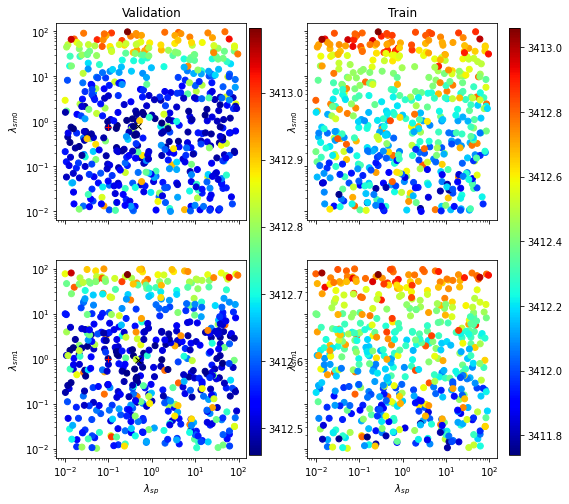

In [21]:
plot_hpm_sca(hpms, restab);

In [27]:
np.random.seed(2022)
hpms1 = hparams_uniform_sample(500, (3e-3,1e4),(5e-3,20),(5e-3,20))
restab1 = cross_val(models, dsets, hpms1, mean_resid)

0it [00:00, ?it/s]

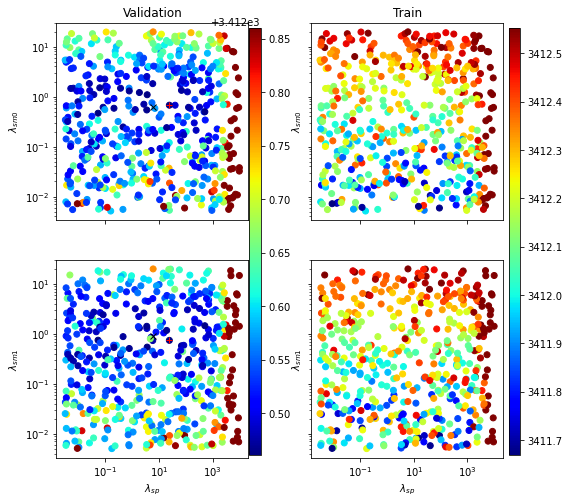

In [33]:
fig, axs, hpmopt = plot_hpm_sca(hpms1, restab1, (0,93));

In [34]:
spook_opt = SpookPosL1(B0, A, "raw", lsparse=hpmopt[0],lsmooth=hpmopt[1:])

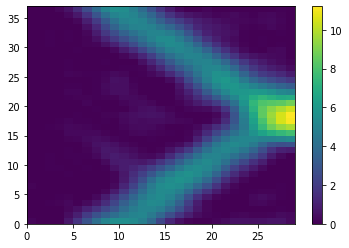

In [35]:
Xo = spook_opt.getXopt()
plt.pcolormesh(Xo)
plt.colorbar()

### Try a diffferent metric
which is $1-\frac{\sum_i b^{(i)}_{pred}\cdot b^{(i)}_{meas}}{\sum_i\|b^{(i)}_{pred}\|\|b^{(i)}_{meas}\|}$

In [49]:
np.random.seed(2022)
hpms1 = hparams_uniform_sample(500, (3e-3,1e4),(5e-3,20),(5e-3,20))
restab1 = cross_val(models, dsets, hpms1, lambda Xo,ds:mean_inprod(Xo,ds,B0,A))

0it [00:00, ?it/s]

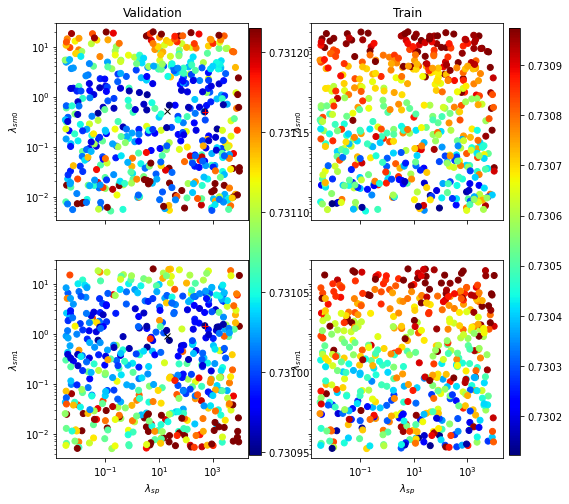

In [50]:
fig, axs, hpmopt = plot_hpm_sca(hpms1, restab1, (0,93));

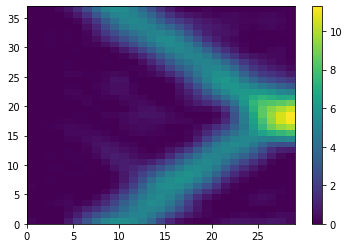

In [56]:
spook_opt = SpookPosL1(B0, A, "raw", lsparse=hpmopt[0],lsmooth=tuple(hpmopt[1:]))
Xo = spook_opt.getXopt()
plt.pcolormesh(Xo)
plt.colorbar()